# Codeword Length = 31, T(seq len)=5, p belongs to {0.001, 0.005, 0.01, 0.05}

In [1]:
# changepoint_detection_updated.py
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
print(os.listdir("/kaggle/input/bsc-bch-codeword-length31"))

['bsc_p0.010_codewords2.csv', 'bsc_p0.005_codewords1.csv', 'bsc_p0.050_codewords2.csv', 'bsc_p0.010_codewords1.csv', 'bsc_p0.001_codewords1.csv', 'bsc_p0.050_codewords1.csv', 'bsc_p0.001_codewords2.csv', 'bsc_p0.005_codewords2.csv']


## p = 0.001

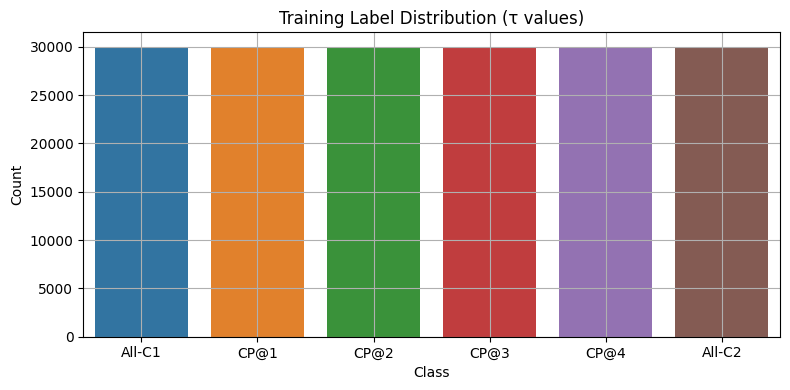

Training Epochs:   2%|▏         | 1/50 [00:17<14:35, 17.87s/it]

Epoch  1 | Train Loss: 1.7945 | Val Accuracy: 0.1759


Training Epochs:   4%|▍         | 2/50 [00:33<13:23, 16.74s/it]

Epoch  2 | Train Loss: 1.7892 | Val Accuracy: 0.2133


Training Epochs:   6%|▌         | 3/50 [00:49<12:50, 16.40s/it]

Epoch  3 | Train Loss: 1.2645 | Val Accuracy: 0.7206


Training Epochs:   8%|▊         | 4/50 [01:05<12:20, 16.10s/it]

Epoch  4 | Train Loss: 0.6262 | Val Accuracy: 0.9112


Training Epochs:  10%|█         | 5/50 [01:21<12:00, 16.02s/it]

Epoch  5 | Train Loss: 0.3878 | Val Accuracy: 0.9381


Training Epochs:  12%|█▏        | 6/50 [01:37<11:41, 15.93s/it]

Epoch  6 | Train Loss: 0.2857 | Val Accuracy: 0.9521


Training Epochs:  14%|█▍        | 7/50 [01:52<11:22, 15.87s/it]

Epoch  7 | Train Loss: 0.2310 | Val Accuracy: 0.9616


Training Epochs:  16%|█▌        | 8/50 [02:08<11:05, 15.85s/it]

Epoch  8 | Train Loss: 0.1988 | Val Accuracy: 0.9659


Training Epochs:  18%|█▊        | 9/50 [02:24<10:50, 15.88s/it]

Epoch  9 | Train Loss: 0.1791 | Val Accuracy: 0.9687


Training Epochs:  20%|██        | 10/50 [02:40<10:34, 15.87s/it]

Epoch 10 | Train Loss: 0.1661 | Val Accuracy: 0.9697


Training Epochs:  22%|██▏       | 11/50 [02:56<10:22, 15.96s/it]

Epoch 11 | Train Loss: 0.1564 | Val Accuracy: 0.9709


Training Epochs:  24%|██▍       | 12/50 [03:12<10:08, 16.00s/it]

Epoch 12 | Train Loss: 0.1505 | Val Accuracy: 0.9716


Training Epochs:  26%|██▌       | 13/50 [03:28<09:49, 15.94s/it]

Epoch 13 | Train Loss: 0.1461 | Val Accuracy: 0.9723


Training Epochs:  28%|██▊       | 14/50 [03:44<09:31, 15.89s/it]

Epoch 14 | Train Loss: 0.1423 | Val Accuracy: 0.9724


Training Epochs:  28%|██▊       | 14/50 [04:00<10:18, 17.17s/it]

Epoch 15 | Train Loss: 0.1384 | Val Accuracy: 0.9727
Early stopping triggered.



Final Test Accuracy: 0.9708


Saved artifacts to Kaggle Output:
  state_dict -> /kaggle/working/cpd_T5_n31_seed0_bsc_p0.001_codewords1_state.pth
  full model -> /kaggle/working/cpd_T5_n31_seed0_bsc_p0.001_codewords1_full.pth
  TorchScript -> /kaggle/working/cpd_T5_n31_seed0_bsc_p0.001_codewords1_model.pt
  metadata -> /kaggle/working/cpd_T5_n31_seed0_bsc_p0.001_codewords1_meta.json
  ZIP bundle  -> /kaggle/working/cpd_T5_n31_seed0_bsc_p0.001_codewords1_artifacts.zip

These appear in the right-side 'Output' panel for download.


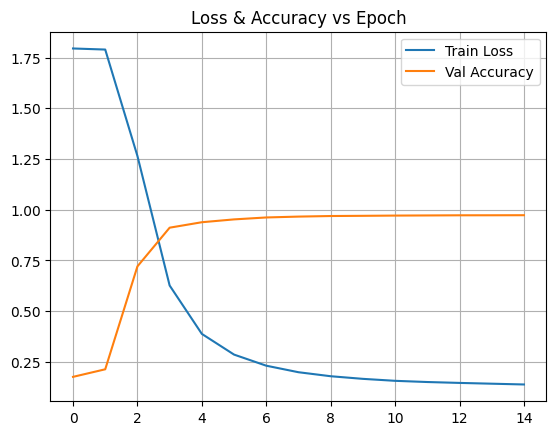

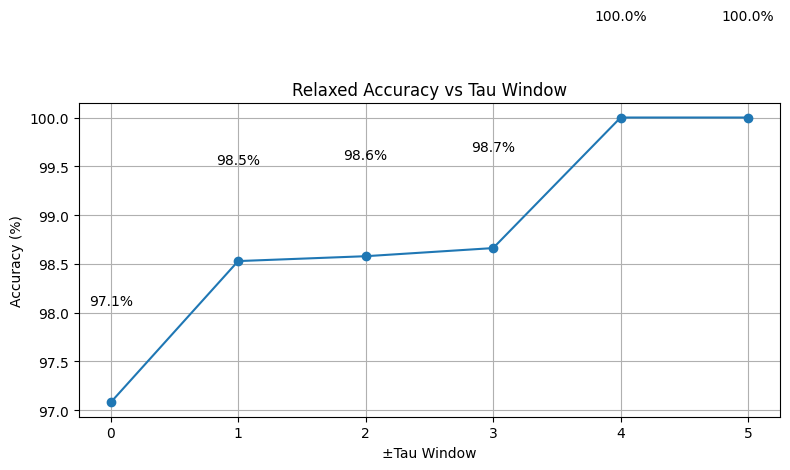

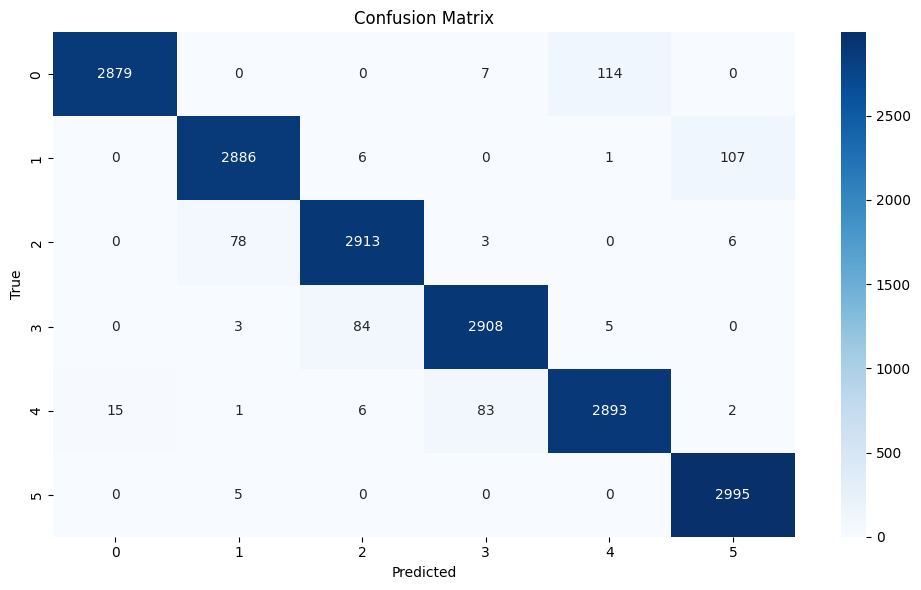

In [3]:
# ===================== Full CPD Window Classifier Training Script =====================

# ---- Imports
import os, json, copy, random, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import trange

# ========== Configuration ==========
SEED = 0
T = 5
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 30000
SAMPLES_PER_CLASS_TEST  = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples 
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1_path = "/kaggle/input/bsc-bch-codeword-length31/bsc_p0.001_codewords1.csv"
csv2_path = "/kaggle/input/bsc-bch-codeword-length31/bsc_p0.001_codewords2.csv"
csv1 = pd.read_csv(csv1_path).values
csv2 = pd.read_csv(csv2_path).values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val,   y_val   = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)
X_test,  y_test  = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)

# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(ChangepointDataset(X_val,   y_val),   batch_size=BATCH_SIZE)
test_loader  = DataLoader(ChangepointDataset(X_test,  y_test),  batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x)
        return self.classifier(x)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = -float("inf")
best_model_state = copy.deepcopy(model.state_dict())
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== SAVE + MAKE DOWNLOADABLE (Kaggle Output) ==========
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Include dataset tag (contains p-value) so files don't overwrite
ds_tag = os.path.splitext(os.path.basename(csv1_path))[0]   # e.g., "bsc_p0.001_codewords1"
prefix = f"cpd_T{T}_n{FEATURE_SIZE}_seed{SEED}_{ds_tag}"

TS_PATH    = os.path.join(OUTPUT_DIR, f"{prefix}_model.pt")   # TorchScript
STATE_PATH = os.path.join(OUTPUT_DIR, f"{prefix}_state.pth")  # state_dict
FULL_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_full.pth")   # full pickled model
META_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_meta.json")  # metadata
ZIP_PATH   = os.path.join(OUTPUT_DIR, f"{prefix}_artifacts.zip")

# 1) Best state_dict (recommended)
torch.save(best_model_state, STATE_PATH)

# 2) Full Python model (optional; tied to this class definition)
torch.save(model, FULL_PATH)

# 3) TorchScript export on CPU (portable)
model_cpu = copy.deepcopy(model).to("cpu").eval()
try:
    scripted = torch.jit.script(model_cpu)
except Exception:
    example = torch.randn(1, T, FEATURE_SIZE)
    scripted = torch.jit.trace(model_cpu, example)
scripted.save(TS_PATH)

# 4) Minimal metadata
label_names = ["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"]
with open(META_PATH, "w") as f:
    json.dump({
        "T": int(T),
        "num_classes": int(NUM_CLASSES),
        "feature_size": int(FEATURE_SIZE),
        "label_names": label_names,
        "seed": int(SEED),
        "best_val_acc": float(best_val_acc),
        "test_strict_acc": float(strict_acc),
        "model_class": model.__class__.__name__,
        "pytorch_version": torch.__version__,
        "csv1": csv1_path,
        "csv2": csv2_path
    }, f, indent=2)

# 5) Bundle everything for one-click download in Kaggle Output
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(STATE_PATH, arcname=os.path.basename(STATE_PATH))
    z.write(FULL_PATH,  arcname=os.path.basename(FULL_PATH))
    z.write(TS_PATH,    arcname=os.path.basename(TS_PATH))
    z.write(META_PATH,  arcname=os.path.basename(META_PATH))

print("\nSaved artifacts to Kaggle Output:")
print("  state_dict ->", STATE_PATH)
print("  full model ->", FULL_PATH)
print("  TorchScript ->", TS_PATH)
print("  metadata ->", META_PATH)
print("  ZIP bundle  ->", ZIP_PATH)
print("\nThese appear in the right-side 'Output' panel for download.")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
# ======================================================================================


***T = 5, p = 0.001, CL = 31, del_window ∈ [1,5], 50 Epochs(if early stopping not triggered)***  </br>
<pre>
For N'(training samples/class) = 1000     Accuracy = 19.5, 48.3, 70.2, 85.5, 96.2, 100.0
For N'(training samples/class) = 2000     Accuracy = 18.5 
For N'(training samples/class) = 3000     Accuracy = 17.8
For N'(training samples/class) = 4000     Accuracy = 17.5
For N'(training samples/class) = 5000     Accuracy = 17.23, 46.3, 68.5, 85.2, 96.2, 100.0
For N'(training samples/class) = 6000     Accuracy = 91.3, 95.8, 95.9, 96.3, 100.0, 100.0
For N'(training samples/class) = 7000     Accuracy = 94.8, 97.3, 97.6, 97.9, 100.0, 100.0
For N'(training samples/class) = 8000     Accuracy = 94.1, 96.9, 97.2, 97.6, 100.0, 100.0 
For N'(training samples/class) = 10000     Accuracy = 95.9, 98.2, 98.3, 98.4, 100.0, 100.0
For N'(training samples/class) = 11000     Accuracy = 96.2
For N'(training samples/class) = 12000     Accuracy = 96.5
For N'(training samples/class) = 15000     Accuracy = 97.0, 98.8, 98.9, 98.9, 100.0, 100.0
For N'(training samples/class) = 20000     Accuracy = 97.2
</pre>

## p = 0.005

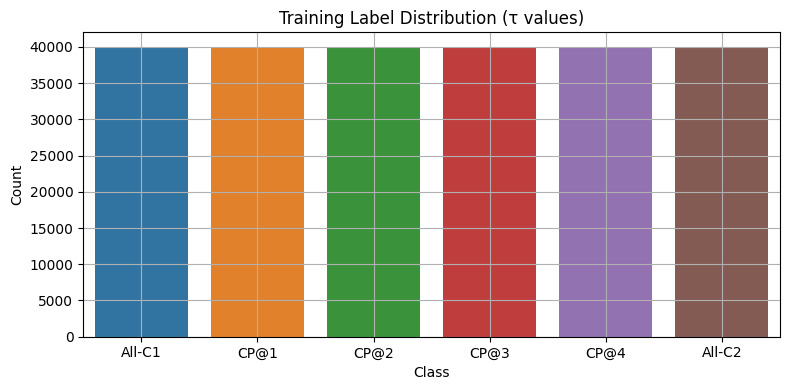

Training Epochs:   2%|▏         | 1/50 [00:21<17:15, 21.14s/it]

Epoch  1 | Train Loss: 1.7940 | Val Accuracy: 0.1795


Training Epochs:   4%|▍         | 2/50 [00:42<16:59, 21.23s/it]

Epoch  2 | Train Loss: 1.6383 | Val Accuracy: 0.5881


Training Epochs:   6%|▌         | 3/50 [01:03<16:40, 21.29s/it]

Epoch  3 | Train Loss: 0.8018 | Val Accuracy: 0.8435


Training Epochs:   8%|▊         | 4/50 [01:24<16:16, 21.22s/it]

Epoch  4 | Train Loss: 0.4782 | Val Accuracy: 0.9126


Training Epochs:  10%|█         | 5/50 [01:46<15:53, 21.18s/it]

Epoch  5 | Train Loss: 0.3386 | Val Accuracy: 0.9376


Training Epochs:  12%|█▏        | 6/50 [02:07<15:33, 21.21s/it]

Epoch  6 | Train Loss: 0.2727 | Val Accuracy: 0.9459


Training Epochs:  14%|█▍        | 7/50 [02:28<15:13, 21.24s/it]

Epoch  7 | Train Loss: 0.2339 | Val Accuracy: 0.9527


Training Epochs:  16%|█▌        | 8/50 [02:49<14:52, 21.25s/it]

Epoch  8 | Train Loss: 0.2111 | Val Accuracy: 0.9578


Training Epochs:  18%|█▊        | 9/50 [03:11<14:34, 21.32s/it]

Epoch  9 | Train Loss: 0.1949 | Val Accuracy: 0.9589


Training Epochs:  20%|██        | 10/50 [03:32<14:12, 21.30s/it]

Epoch 10 | Train Loss: 0.1826 | Val Accuracy: 0.9608


Training Epochs:  22%|██▏       | 11/50 [03:53<13:48, 21.25s/it]

Epoch 11 | Train Loss: 0.1745 | Val Accuracy: 0.9628


Training Epochs:  24%|██▍       | 12/50 [04:15<13:28, 21.26s/it]

Epoch 12 | Train Loss: 0.1680 | Val Accuracy: 0.9628


Training Epochs:  26%|██▌       | 13/50 [04:36<13:05, 21.23s/it]

Epoch 13 | Train Loss: 0.1612 | Val Accuracy: 0.9643


Training Epochs:  28%|██▊       | 14/50 [04:57<12:47, 21.31s/it]

Epoch 14 | Train Loss: 0.1569 | Val Accuracy: 0.9648


Training Epochs:  30%|███       | 15/50 [05:18<12:25, 21.31s/it]

Epoch 15 | Train Loss: 0.1533 | Val Accuracy: 0.9663


Training Epochs:  32%|███▏      | 16/50 [05:40<12:03, 21.28s/it]

Epoch 16 | Train Loss: 0.1484 | Val Accuracy: 0.9663


Training Epochs:  34%|███▍      | 17/50 [06:01<11:40, 21.23s/it]

Epoch 17 | Train Loss: 0.1452 | Val Accuracy: 0.9669


Training Epochs:  36%|███▌      | 18/50 [06:22<11:18, 21.22s/it]

Epoch 18 | Train Loss: 0.1432 | Val Accuracy: 0.9670


Training Epochs:  36%|███▌      | 18/50 [06:43<11:57, 22.43s/it]

Epoch 19 | Train Loss: 0.1405 | Val Accuracy: 0.9679
Early stopping triggered.



Final Test Accuracy: 0.9658


Saved artifacts to Kaggle Output:
  state_dict -> /kaggle/working/cpd_T5_n31_seed0_bsc_p0.005_codewords1_state.pth
  full model -> /kaggle/working/cpd_T5_n31_seed0_bsc_p0.005_codewords1_full.pth
  TorchScript -> /kaggle/working/cpd_T5_n31_seed0_bsc_p0.005_codewords1_model.pt
  metadata -> /kaggle/working/cpd_T5_n31_seed0_bsc_p0.005_codewords1_meta.json
  ZIP bundle  -> /kaggle/working/cpd_T5_n31_seed0_bsc_p0.005_codewords1_artifacts.zip

These appear in the right-side 'Output' panel for download.


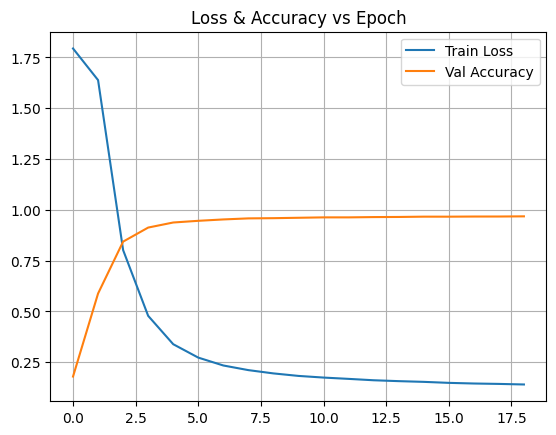

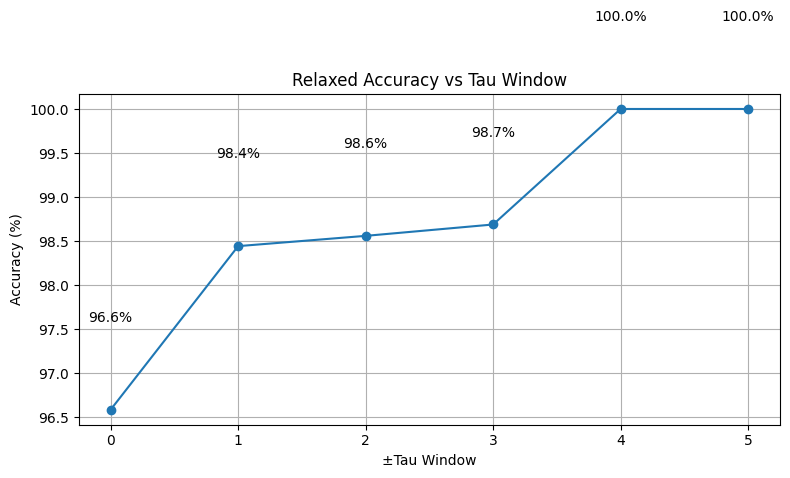

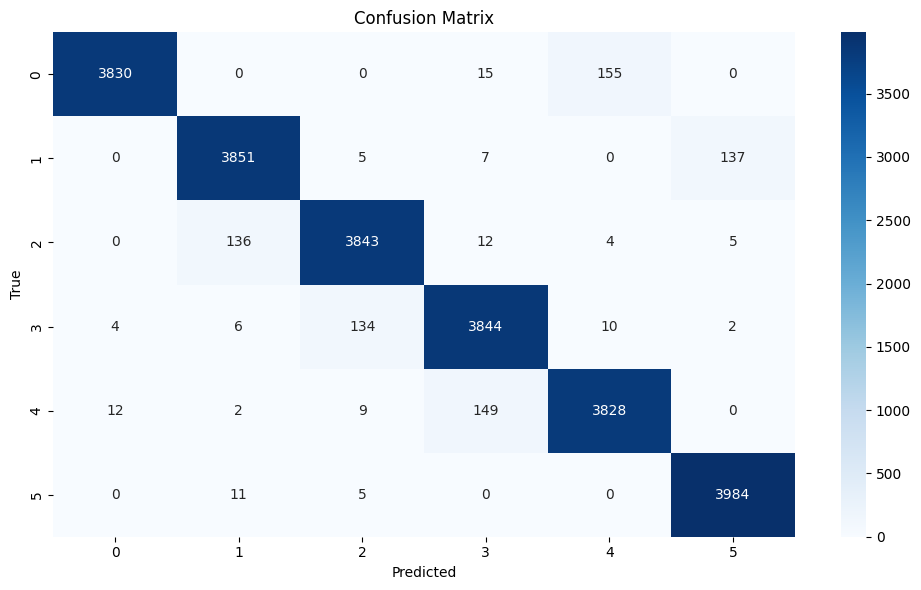

In [4]:
# ===================== Full CPD Window Classifier Training Script =====================

# ---- Imports
import os, json, copy, random, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import trange

# ========== Configuration ==========
SEED = 0
T = 5
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 40000
SAMPLES_PER_CLASS_TEST  = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples 
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1_path = "/kaggle/input/bsc-bch-codeword-length31/bsc_p0.005_codewords1.csv"
csv2_path = "/kaggle/input/bsc-bch-codeword-length31/bsc_p0.005_codewords2.csv"
csv1 = pd.read_csv(csv1_path).values
csv2 = pd.read_csv(csv2_path).values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val,   y_val   = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)
X_test,  y_test  = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)

# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(ChangepointDataset(X_val,   y_val),   batch_size=BATCH_SIZE)
test_loader  = DataLoader(ChangepointDataset(X_test,  y_test),  batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x)
        return self.classifier(x)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = -float("inf")
best_model_state = copy.deepcopy(model.state_dict())
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== SAVE + MAKE DOWNLOADABLE (Kaggle Output) ==========
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Include dataset tag (contains p-value) so files don't overwrite
ds_tag = os.path.splitext(os.path.basename(csv1_path))[0]   # e.g., "bsc_p0.001_codewords1"
prefix = f"cpd_T{T}_n{FEATURE_SIZE}_seed{SEED}_{ds_tag}"

TS_PATH    = os.path.join(OUTPUT_DIR, f"{prefix}_model.pt")   # TorchScript
STATE_PATH = os.path.join(OUTPUT_DIR, f"{prefix}_state.pth")  # state_dict
FULL_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_full.pth")   # full pickled model
META_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_meta.json")  # metadata
ZIP_PATH   = os.path.join(OUTPUT_DIR, f"{prefix}_artifacts.zip")

# 1) Best state_dict (recommended)
torch.save(best_model_state, STATE_PATH)

# 2) Full Python model (optional; tied to this class definition)
torch.save(model, FULL_PATH)

# 3) TorchScript export on CPU (portable)
model_cpu = copy.deepcopy(model).to("cpu").eval()
try:
    scripted = torch.jit.script(model_cpu)
except Exception:
    example = torch.randn(1, T, FEATURE_SIZE)
    scripted = torch.jit.trace(model_cpu, example)
scripted.save(TS_PATH)

# 4) Minimal metadata
label_names = ["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"]
with open(META_PATH, "w") as f:
    json.dump({
        "T": int(T),
        "num_classes": int(NUM_CLASSES),
        "feature_size": int(FEATURE_SIZE),
        "label_names": label_names,
        "seed": int(SEED),
        "best_val_acc": float(best_val_acc),
        "test_strict_acc": float(strict_acc),
        "model_class": model.__class__.__name__,
        "pytorch_version": torch.__version__,
        "csv1": csv1_path,
        "csv2": csv2_path
    }, f, indent=2)

# 5) Bundle everything for one-click download in Kaggle Output
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(STATE_PATH, arcname=os.path.basename(STATE_PATH))
    z.write(FULL_PATH,  arcname=os.path.basename(FULL_PATH))
    z.write(TS_PATH,    arcname=os.path.basename(TS_PATH))
    z.write(META_PATH,  arcname=os.path.basename(META_PATH))

print("\nSaved artifacts to Kaggle Output:")
print("  state_dict ->", STATE_PATH)
print("  full model ->", FULL_PATH)
print("  TorchScript ->", TS_PATH)
print("  metadata ->", META_PATH)
print("  ZIP bundle  ->", ZIP_PATH)
print("\nThese appear in the right-side 'Output' panel for download.")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
# ======================================================================================


***T = 5, p = 0.005, CL = 31, del_window ∈ [1,5], 50 Epochs(if early stopping not triggered)***  </br>
<pre>
For N'(training samples/class) = 1000     Accuracy = 15.7, 46.3, 67.3, 83.3, 95.0, 100.0
For N'(training samples/class) = 2000     Accuracy = 16.2
For N'(training samples/class) = 3000     Accuracy = 16.1
For N'(training samples/class) = 4000     Accuracy = 16.6
For N'(training samples/class) = 5000     Accuracy = 16.3, 46.1, 67.8, 83.7, 96.3, 100
For N'(training samples/class) = 6000     Accuracy = 91.5, 96.1, 96.3, 96.8, 100.0, 100.0
For N'(training samples/class) = 8000     Accuracy = 93.8, 97.1, 97.4, 97.8, 100.0, 100.0
For N'(training samples/class) = 10000     Accuracy = 95.0, 97.5, 97.7, 98.0, 100.0, 100.0
For N'(training samples/class) = 11000     Accuracy = 95.3
For N'(training samples/class) = 12000     Accuracy = 95.4
For N'(training samples/class) = 15000     Accuracy = 96.8, 98.5, 98.6, 98.8, 100.0, 100.0
For N'(training samples/class) = 20000     Accuracy =
</pre>

## p = 0.01

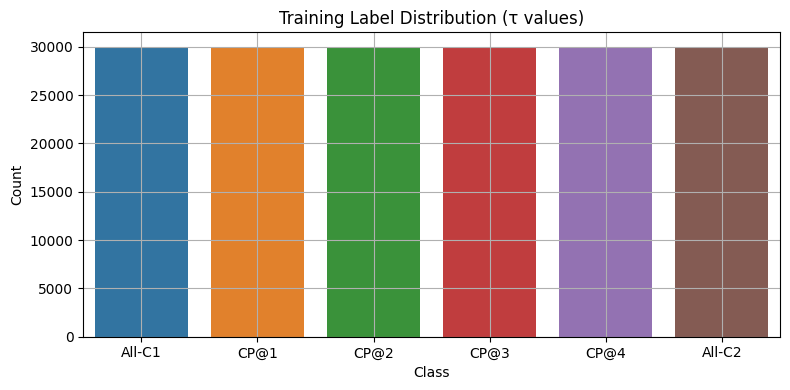

Training Epochs:   2%|▏         | 1/50 [00:15<12:51, 15.74s/it]

Epoch  1 | Train Loss: 1.7946 | Val Accuracy: 0.1698


Training Epochs:   4%|▍         | 2/50 [00:31<12:39, 15.82s/it]

Epoch  2 | Train Loss: 1.7903 | Val Accuracy: 0.1921


Training Epochs:   6%|▌         | 3/50 [00:47<12:32, 16.01s/it]

Epoch  3 | Train Loss: 1.4324 | Val Accuracy: 0.6205


Training Epochs:   8%|▊         | 4/50 [01:03<12:17, 16.03s/it]

Epoch  4 | Train Loss: 0.8078 | Val Accuracy: 0.8270


Training Epochs:  10%|█         | 5/50 [01:19<12:00, 16.01s/it]

Epoch  5 | Train Loss: 0.5563 | Val Accuracy: 0.8825


Training Epochs:  12%|█▏        | 6/50 [01:35<11:46, 16.05s/it]

Epoch  6 | Train Loss: 0.4249 | Val Accuracy: 0.9131


Training Epochs:  14%|█▍        | 7/50 [01:51<11:25, 15.95s/it]

Epoch  7 | Train Loss: 0.3440 | Val Accuracy: 0.9337


Training Epochs:  16%|█▌        | 8/50 [02:07<11:08, 15.92s/it]

Epoch  8 | Train Loss: 0.2916 | Val Accuracy: 0.9428


Training Epochs:  18%|█▊        | 9/50 [02:23<10:55, 16.00s/it]

Epoch  9 | Train Loss: 0.2566 | Val Accuracy: 0.9494


Training Epochs:  20%|██        | 10/50 [02:39<10:42, 16.05s/it]

Epoch 10 | Train Loss: 0.2319 | Val Accuracy: 0.9542


Training Epochs:  22%|██▏       | 11/50 [02:55<10:23, 15.98s/it]

Epoch 11 | Train Loss: 0.2158 | Val Accuracy: 0.9561


Training Epochs:  24%|██▍       | 12/50 [03:12<10:10, 16.06s/it]

Epoch 12 | Train Loss: 0.2021 | Val Accuracy: 0.9579


Training Epochs:  26%|██▌       | 13/50 [03:27<09:50, 15.96s/it]

Epoch 13 | Train Loss: 0.1924 | Val Accuracy: 0.9604


Training Epochs:  28%|██▊       | 14/50 [03:43<09:36, 16.01s/it]

Epoch 14 | Train Loss: 0.1836 | Val Accuracy: 0.9605


Training Epochs:  30%|███       | 15/50 [03:59<09:19, 15.98s/it]

Epoch 15 | Train Loss: 0.1774 | Val Accuracy: 0.9606


Training Epochs:  32%|███▏      | 16/50 [04:15<09:03, 15.98s/it]

Epoch 16 | Train Loss: 0.1717 | Val Accuracy: 0.9617


Training Epochs:  34%|███▍      | 17/50 [04:31<08:45, 15.91s/it]

Epoch 17 | Train Loss: 0.1668 | Val Accuracy: 0.9627


Training Epochs:  36%|███▌      | 18/50 [04:47<08:29, 15.92s/it]

Epoch 18 | Train Loss: 0.1645 | Val Accuracy: 0.9626


Training Epochs:  38%|███▊      | 19/50 [05:03<08:13, 15.93s/it]

Epoch 19 | Train Loss: 0.1598 | Val Accuracy: 0.9643


Training Epochs:  40%|████      | 20/50 [05:19<07:57, 15.92s/it]

Epoch 20 | Train Loss: 0.1574 | Val Accuracy: 0.9653


Training Epochs:  42%|████▏     | 21/50 [05:35<07:44, 16.01s/it]

Epoch 21 | Train Loss: 0.1539 | Val Accuracy: 0.9641


Training Epochs:  44%|████▍     | 22/50 [05:51<07:27, 15.98s/it]

Epoch 22 | Train Loss: 0.1509 | Val Accuracy: 0.9644


Training Epochs:  46%|████▌     | 23/50 [06:07<07:13, 16.05s/it]

Epoch 23 | Train Loss: 0.1484 | Val Accuracy: 0.9641


Training Epochs:  46%|████▌     | 23/50 [06:23<07:30, 16.68s/it]

Epoch 24 | Train Loss: 0.1470 | Val Accuracy: 0.9647
Early stopping triggered.



Final Test Accuracy: 0.9628


Saved artifacts to Kaggle Output:
  state_dict -> /kaggle/working/cpd_T5_n31_seed0_bsc_p0.010_codewords1_state.pth
  full model -> /kaggle/working/cpd_T5_n31_seed0_bsc_p0.010_codewords1_full.pth
  TorchScript -> /kaggle/working/cpd_T5_n31_seed0_bsc_p0.010_codewords1_model.pt
  metadata -> /kaggle/working/cpd_T5_n31_seed0_bsc_p0.010_codewords1_meta.json
  ZIP bundle  -> /kaggle/working/cpd_T5_n31_seed0_bsc_p0.010_codewords1_artifacts.zip

These appear in the right-side 'Output' panel for download.


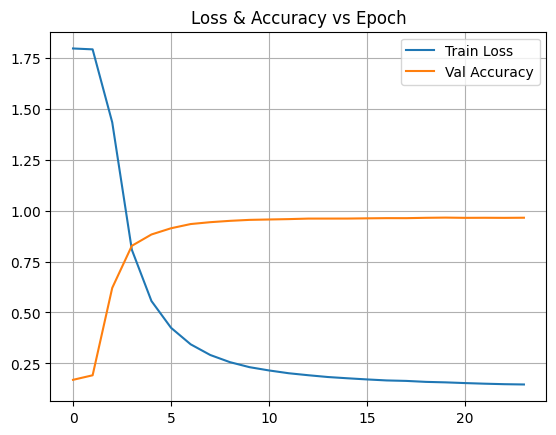

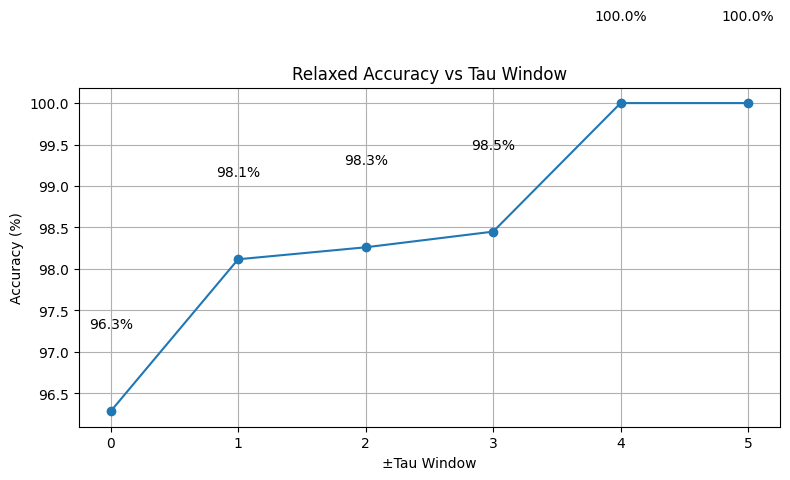

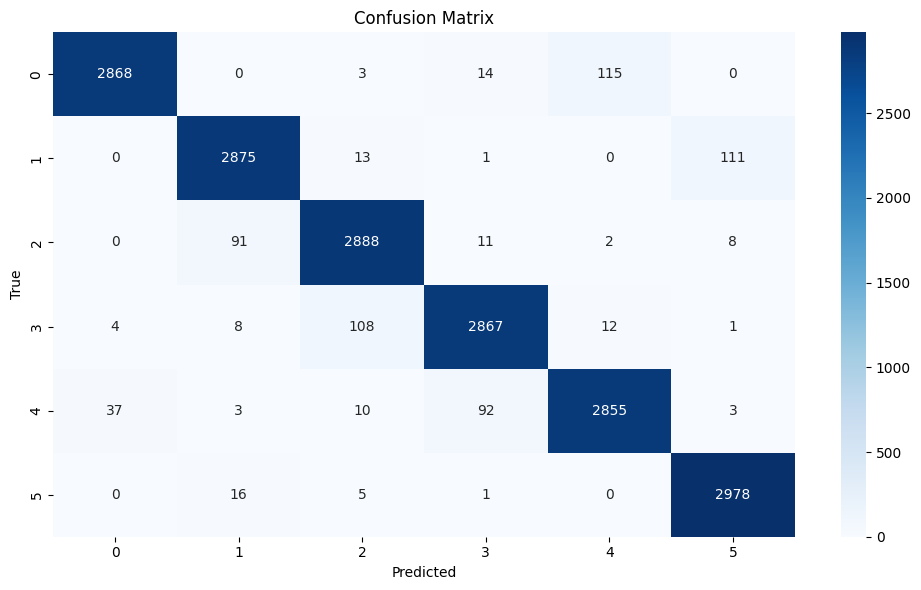

In [5]:
# ===================== Full CPD Window Classifier Training Script =====================

# ---- Imports
import os, json, copy, random, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import trange

# ========== Configuration ==========
SEED = 0
T = 5
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 30000
SAMPLES_PER_CLASS_TEST  = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples 
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1_path = "/kaggle/input/bsc-bch-codeword-length31/bsc_p0.010_codewords1.csv"
csv2_path = "/kaggle/input/bsc-bch-codeword-length31/bsc_p0.010_codewords2.csv"
csv1 = pd.read_csv(csv1_path).values
csv2 = pd.read_csv(csv2_path).values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val,   y_val   = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)
X_test,  y_test  = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)

# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(ChangepointDataset(X_val,   y_val),   batch_size=BATCH_SIZE)
test_loader  = DataLoader(ChangepointDataset(X_test,  y_test),  batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x)
        return self.classifier(x)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = -float("inf")
best_model_state = copy.deepcopy(model.state_dict())
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== SAVE + MAKE DOWNLOADABLE (Kaggle Output) ==========
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Include dataset tag (contains p-value) so files don't overwrite
ds_tag = os.path.splitext(os.path.basename(csv1_path))[0]   # e.g., "bsc_p0.001_codewords1"
prefix = f"cpd_T{T}_n{FEATURE_SIZE}_seed{SEED}_{ds_tag}"

TS_PATH    = os.path.join(OUTPUT_DIR, f"{prefix}_model.pt")   # TorchScript
STATE_PATH = os.path.join(OUTPUT_DIR, f"{prefix}_state.pth")  # state_dict
FULL_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_full.pth")   # full pickled model
META_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_meta.json")  # metadata
ZIP_PATH   = os.path.join(OUTPUT_DIR, f"{prefix}_artifacts.zip")

# 1) Best state_dict (recommended)
torch.save(best_model_state, STATE_PATH)

# 2) Full Python model (optional; tied to this class definition)
torch.save(model, FULL_PATH)

# 3) TorchScript export on CPU (portable)
model_cpu = copy.deepcopy(model).to("cpu").eval()
try:
    scripted = torch.jit.script(model_cpu)
except Exception:
    example = torch.randn(1, T, FEATURE_SIZE)
    scripted = torch.jit.trace(model_cpu, example)
scripted.save(TS_PATH)

# 4) Minimal metadata
label_names = ["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"]
with open(META_PATH, "w") as f:
    json.dump({
        "T": int(T),
        "num_classes": int(NUM_CLASSES),
        "feature_size": int(FEATURE_SIZE),
        "label_names": label_names,
        "seed": int(SEED),
        "best_val_acc": float(best_val_acc),
        "test_strict_acc": float(strict_acc),
        "model_class": model.__class__.__name__,
        "pytorch_version": torch.__version__,
        "csv1": csv1_path,
        "csv2": csv2_path
    }, f, indent=2)

# 5) Bundle everything for one-click download in Kaggle Output
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(STATE_PATH, arcname=os.path.basename(STATE_PATH))
    z.write(FULL_PATH,  arcname=os.path.basename(FULL_PATH))
    z.write(TS_PATH,    arcname=os.path.basename(TS_PATH))
    z.write(META_PATH,  arcname=os.path.basename(META_PATH))

print("\nSaved artifacts to Kaggle Output:")
print("  state_dict ->", STATE_PATH)
print("  full model ->", FULL_PATH)
print("  TorchScript ->", TS_PATH)
print("  metadata ->", META_PATH)
print("  ZIP bundle  ->", ZIP_PATH)
print("\nThese appear in the right-side 'Output' panel for download.")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
# ======================================================================================


***T = 5, p = 0.010, CL = 31, del_window ∈ [1,5], 50 Epochs(if early stopping not triggered)***  </br>
<pre>
For N'(training samples/class) = 1000     Accuracy = 17.5
For N'(training samples/class) = 2000     Accuracy = 18.1
For N'(training samples/class) = 3000     Accuracy = 18.2
For N'(training samples/class) = 4000     Accuracy = 18.5, 45.5, 69.3, 86.4, 95.2, 100.0
For N'(training samples/class) = 5000     Accuracy = 16.3, 45.7, 68.9, 84.6, 95.9, 100.0
For N'(training samples/class) = 6000     Accuracy = 90.3, 95.1, 95.7, 96.4, 100.0, 100.0 
For N'(training samples/class) = 8000     Accuracy = 89.5, 94.5, 95.2, 96.1, 100.0, 100.0
For N'(training samples/class) = 10000     Accuracy = 95.0, 97.8, 98.0, 98.2, 100.0, 100.0
For N'(training samples/class) = 11000     Accuracy = 95.3
For N'(training samples/class) = 12000     Accuracy = 95.7
For N'(training samples/class) = 15000     Accuracy = 96.3, 98.2, 98.4, 98.6, 100.0, 100.0
For N'(training samples/class) = 30000     Accuracy =
For N'(training samples/class) = 45000     Accuracy =
</pre>

## p = 0.05

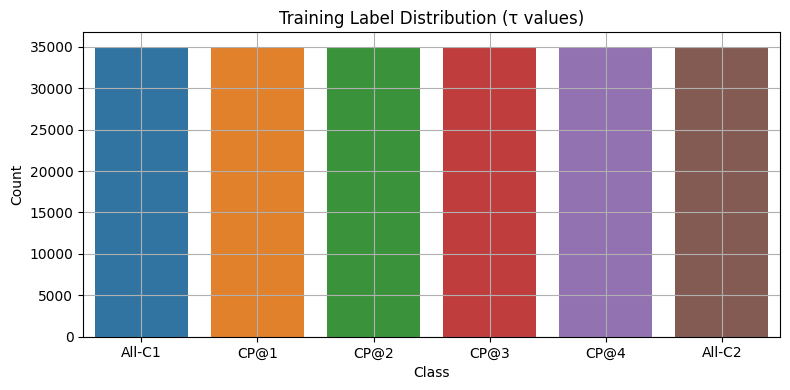

Training Epochs:   2%|▏         | 1/50 [00:18<15:18, 18.75s/it]

Epoch  1 | Train Loss: 1.7943 | Val Accuracy: 0.1661


Training Epochs:   4%|▍         | 2/50 [00:37<14:57, 18.70s/it]

Epoch  2 | Train Loss: 1.7916 | Val Accuracy: 0.1748


Training Epochs:   6%|▌         | 3/50 [00:56<14:41, 18.76s/it]

Epoch  3 | Train Loss: 1.7857 | Val Accuracy: 0.2403


Training Epochs:   8%|▊         | 4/50 [01:15<14:23, 18.77s/it]

Epoch  4 | Train Loss: 1.4575 | Val Accuracy: 0.4953


Training Epochs:  10%|█         | 5/50 [01:33<14:00, 18.68s/it]

Epoch  5 | Train Loss: 1.1107 | Val Accuracy: 0.6362


Training Epochs:  12%|█▏        | 6/50 [01:52<13:41, 18.66s/it]

Epoch  6 | Train Loss: 0.9100 | Val Accuracy: 0.7307


Training Epochs:  14%|█▍        | 7/50 [02:10<13:17, 18.54s/it]

Epoch  7 | Train Loss: 0.7697 | Val Accuracy: 0.7781


Training Epochs:  16%|█▌        | 8/50 [02:28<12:55, 18.46s/it]

Epoch  8 | Train Loss: 0.6763 | Val Accuracy: 0.8067


Training Epochs:  18%|█▊        | 9/50 [02:47<12:38, 18.49s/it]

Epoch  9 | Train Loss: 0.6128 | Val Accuracy: 0.8245


Training Epochs:  20%|██        | 10/50 [03:05<12:20, 18.52s/it]

Epoch 10 | Train Loss: 0.5536 | Val Accuracy: 0.8470


Training Epochs:  22%|██▏       | 11/50 [03:24<12:04, 18.59s/it]

Epoch 11 | Train Loss: 0.5007 | Val Accuracy: 0.8597


Training Epochs:  24%|██▍       | 12/50 [03:43<11:47, 18.61s/it]

Epoch 12 | Train Loss: 0.4639 | Val Accuracy: 0.8684


Training Epochs:  26%|██▌       | 13/50 [04:02<11:29, 18.64s/it]

Epoch 13 | Train Loss: 0.4345 | Val Accuracy: 0.8774


Training Epochs:  28%|██▊       | 14/50 [04:20<11:09, 18.59s/it]

Epoch 14 | Train Loss: 0.4098 | Val Accuracy: 0.8868


Training Epochs:  30%|███       | 15/50 [04:39<10:50, 18.58s/it]

Epoch 15 | Train Loss: 0.3877 | Val Accuracy: 0.8915


Training Epochs:  32%|███▏      | 16/50 [04:57<10:30, 18.55s/it]

Epoch 16 | Train Loss: 0.3723 | Val Accuracy: 0.8958


Training Epochs:  34%|███▍      | 17/50 [05:16<10:12, 18.55s/it]

Epoch 17 | Train Loss: 0.3547 | Val Accuracy: 0.9018


Training Epochs:  36%|███▌      | 18/50 [05:34<09:55, 18.61s/it]

Epoch 18 | Train Loss: 0.3429 | Val Accuracy: 0.9030


Training Epochs:  38%|███▊      | 19/50 [05:53<09:35, 18.57s/it]

Epoch 19 | Train Loss: 0.3320 | Val Accuracy: 0.9049


Training Epochs:  40%|████      | 20/50 [06:12<09:19, 18.65s/it]

Epoch 20 | Train Loss: 0.3211 | Val Accuracy: 0.9081


Training Epochs:  42%|████▏     | 21/50 [06:30<09:02, 18.71s/it]

Epoch 21 | Train Loss: 0.3157 | Val Accuracy: 0.9106


Training Epochs:  44%|████▍     | 22/50 [06:49<08:43, 18.69s/it]

Epoch 22 | Train Loss: 0.3081 | Val Accuracy: 0.9112


Training Epochs:  46%|████▌     | 23/50 [07:08<08:23, 18.65s/it]

Epoch 23 | Train Loss: 0.3002 | Val Accuracy: 0.9126


Training Epochs:  48%|████▊     | 24/50 [07:26<08:04, 18.63s/it]

Epoch 24 | Train Loss: 0.2941 | Val Accuracy: 0.9143


Training Epochs:  50%|█████     | 25/50 [07:45<07:45, 18.64s/it]

Epoch 25 | Train Loss: 0.2893 | Val Accuracy: 0.9130


Training Epochs:  52%|█████▏    | 26/50 [08:03<07:24, 18.53s/it]

Epoch 26 | Train Loss: 0.2838 | Val Accuracy: 0.9149


Training Epochs:  54%|█████▍    | 27/50 [08:22<07:07, 18.57s/it]

Epoch 27 | Train Loss: 0.2794 | Val Accuracy: 0.9158


Training Epochs:  56%|█████▌    | 28/50 [08:40<06:47, 18.53s/it]

Epoch 28 | Train Loss: 0.2757 | Val Accuracy: 0.9155


Training Epochs:  58%|█████▊    | 29/50 [08:59<06:29, 18.53s/it]

Epoch 29 | Train Loss: 0.2711 | Val Accuracy: 0.9169


Training Epochs:  60%|██████    | 30/50 [09:18<06:11, 18.59s/it]

Epoch 30 | Train Loss: 0.2674 | Val Accuracy: 0.9167


Training Epochs:  62%|██████▏   | 31/50 [09:36<05:53, 18.59s/it]

Epoch 31 | Train Loss: 0.2631 | Val Accuracy: 0.9176


Training Epochs:  64%|██████▍   | 32/50 [09:55<05:34, 18.61s/it]

Epoch 32 | Train Loss: 0.2603 | Val Accuracy: 0.9192


Training Epochs:  66%|██████▌   | 33/50 [10:13<05:15, 18.57s/it]

Epoch 33 | Train Loss: 0.2578 | Val Accuracy: 0.9161


Training Epochs:  68%|██████▊   | 34/50 [10:32<04:57, 18.59s/it]

Epoch 34 | Train Loss: 0.2531 | Val Accuracy: 0.9184


Training Epochs:  70%|███████   | 35/50 [10:50<04:37, 18.51s/it]

Epoch 35 | Train Loss: 0.2506 | Val Accuracy: 0.9181


Training Epochs:  70%|███████   | 35/50 [11:09<04:46, 19.12s/it]

Epoch 36 | Train Loss: 0.2454 | Val Accuracy: 0.9191
Early stopping triggered.



Final Test Accuracy: 0.9210


Saved artifacts to Kaggle Output:
  state_dict -> /kaggle/working/cpd_T5_n31_seed0_bsc_p0.050_codewords1_state.pth
  full model -> /kaggle/working/cpd_T5_n31_seed0_bsc_p0.050_codewords1_full.pth
  TorchScript -> /kaggle/working/cpd_T5_n31_seed0_bsc_p0.050_codewords1_model.pt
  metadata -> /kaggle/working/cpd_T5_n31_seed0_bsc_p0.050_codewords1_meta.json
  ZIP bundle  -> /kaggle/working/cpd_T5_n31_seed0_bsc_p0.050_codewords1_artifacts.zip

These appear in the right-side 'Output' panel for download.


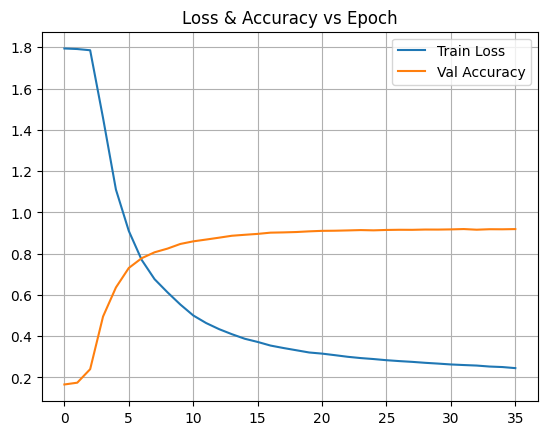

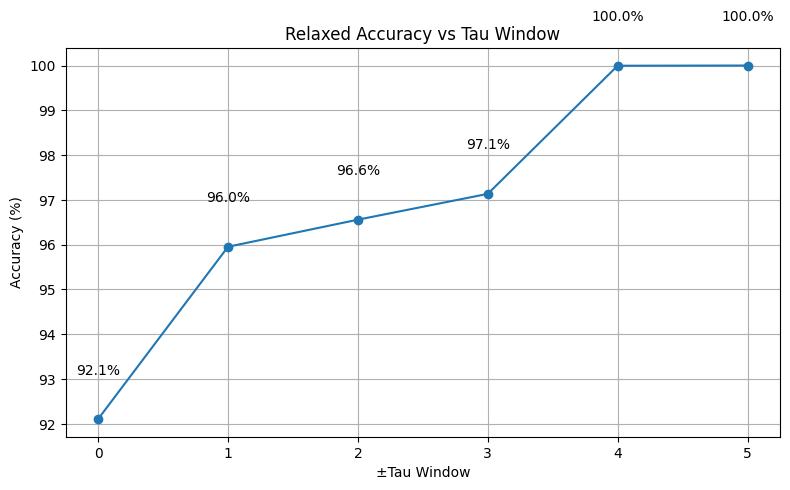

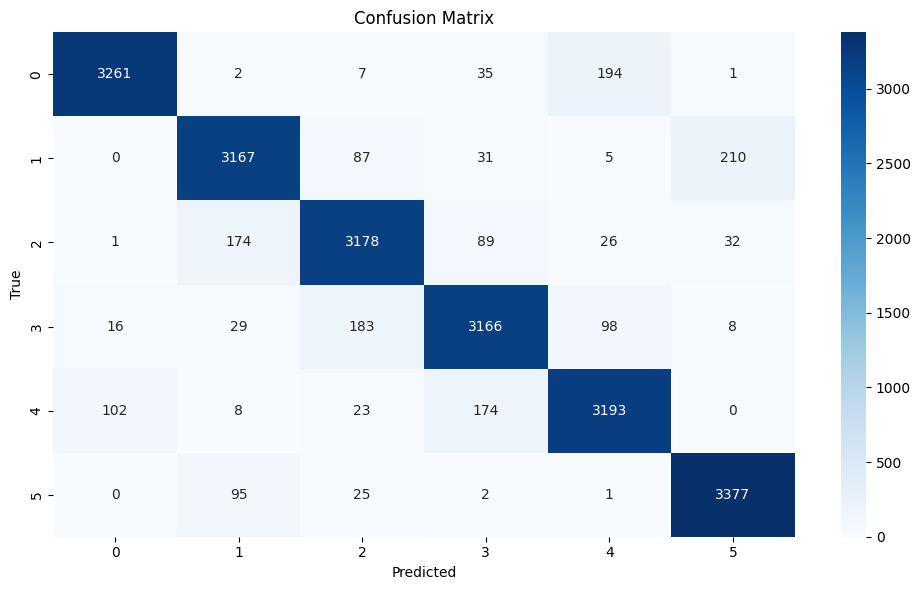

In [6]:
# ===================== Full CPD Window Classifier Training Script =====================

# ---- Imports
import os, json, copy, random, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import trange

# ========== Configuration ==========
SEED = 0
T = 5
NUM_CLASSES = T + 1
SAMPLES_PER_CLASS_TRAIN = 35000
SAMPLES_PER_CLASS_TEST  = int(0.1 * SAMPLES_PER_CLASS_TRAIN)  # 10% of training samples 
BATCH_SIZE = 64
PATIENCE = 4
VAL_DELTA = 0.002
LEARNING_RATE = 1e-4
MAX_EPOCHS = 50

# ========== Set Seeds ==========
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# ========== Load Data ==========
csv1_path = "/kaggle/input/bsc-bch-codeword-length31/bsc_p0.050_codewords1.csv"
csv2_path = "/kaggle/input/bsc-bch-codeword-length31/bsc_p0.050_codewords2.csv"
csv1 = pd.read_csv(csv1_path).values
csv2 = pd.read_csv(csv2_path).values
FEATURE_SIZE = csv1.shape[1]

# ========== Updated CPD Dataset Generator ==========
def generate_data_cpd(N_per_class, csv1_data, csv2_data, T):
    Data, Labels = [], []
    for cls in range(NUM_CLASSES):
        for _ in range(N_per_class):
            if cls == 0:
                indices = np.random.choice(len(csv1_data), T)
                sample = csv1_data[indices]
            elif cls == T:
                indices = np.random.choice(len(csv2_data), T)
                sample = csv2_data[indices]
            else:
                tau = cls
                idx1 = np.random.choice(len(csv1_data), tau, replace=True)
                idx2 = np.random.choice(len(csv2_data), T - tau, replace=True)
                sample = np.vstack((csv1_data[idx1], csv2_data[idx2]))
            Data.append(sample)
            Labels.append(cls)
    return np.array(Data), np.array(Labels)

# ========== Create Datasets ==========
X_train, y_train = generate_data_cpd(SAMPLES_PER_CLASS_TRAIN, csv1, csv2, T)
X_val,   y_val   = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)
X_test,  y_test  = generate_data_cpd(SAMPLES_PER_CLASS_TEST,  csv1, csv2, T)

# ========== Plot Label Distribution ==========
plt.figure(figsize=(8, 4))
sns.countplot(x=y_train, palette="tab10")
plt.title("Training Label Distribution (τ values)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"])
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Dataset Wrapper ==========
class ChangepointDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ChangepointDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(ChangepointDataset(X_val,   y_val),   batch_size=BATCH_SIZE)
test_loader  = DataLoader(ChangepointDataset(X_test,  y_test),  batch_size=BATCH_SIZE)

# ========== Model ==========
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.shortcut = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_sc = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        identity = self.bn_sc(self.shortcut(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.bn2(self.conv2(x))
        return F.relu(x + identity)

class MultiscaleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.branch2 = nn.Conv1d(in_channels, out_channels, kernel_size=5, padding=2)
        self.branch3 = nn.Conv1d(in_channels, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat([x1, x2, x3], dim=1)
        return F.relu(self.bn(x_cat))

class CNNChangepointDetector(nn.Module):
    def __init__(self, input_channels, num_classes, input_length):
        super().__init__()
        self.mfe = MultiscaleFeatureExtractor(input_channels, 32)
        if input_length <= 15:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
            )
        else:
            self.res_blocks = nn.Sequential(
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 96),
                ResidualBlock1D(96, 128),
                ResidualBlock1D(128, 128),
            )
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.mfe(x)
        x = self.res_blocks(x)
        x = self.global_avg_pool(x)
        return self.classifier(x)

# ========== Training ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNChangepointDetector(input_channels=FEATURE_SIZE, num_classes=NUM_CLASSES, input_length=T).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

best_val_acc = -float("inf")
best_model_state = copy.deepcopy(model.state_dict())
epochs_no_improve = 0
train_losses, val_accuracies = [], []

for epoch in trange(MAX_EPOCHS, desc="Training Epochs"):
    model.train()
    running_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model(Xb)
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Accuracy: {val_acc:.4f}")

    if val_acc - best_val_acc > VAL_DELTA:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# ========== Evaluation ==========
model.load_state_dict(best_model_state)
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_targets.extend(yb.numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)
strict_acc = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {strict_acc:.4f}\n")

# ========== SAVE + MAKE DOWNLOADABLE (Kaggle Output) ==========
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Include dataset tag (contains p-value) so files don't overwrite
ds_tag = os.path.splitext(os.path.basename(csv1_path))[0]   # e.g., "bsc_p0.001_codewords1"
prefix = f"cpd_T{T}_n{FEATURE_SIZE}_seed{SEED}_{ds_tag}"

TS_PATH    = os.path.join(OUTPUT_DIR, f"{prefix}_model.pt")   # TorchScript
STATE_PATH = os.path.join(OUTPUT_DIR, f"{prefix}_state.pth")  # state_dict
FULL_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_full.pth")   # full pickled model
META_PATH  = os.path.join(OUTPUT_DIR, f"{prefix}_meta.json")  # metadata
ZIP_PATH   = os.path.join(OUTPUT_DIR, f"{prefix}_artifacts.zip")

# 1) Best state_dict (recommended)
torch.save(best_model_state, STATE_PATH)

# 2) Full Python model (optional; tied to this class definition)
torch.save(model, FULL_PATH)

# 3) TorchScript export on CPU (portable)
model_cpu = copy.deepcopy(model).to("cpu").eval()
try:
    scripted = torch.jit.script(model_cpu)
except Exception:
    example = torch.randn(1, T, FEATURE_SIZE)
    scripted = torch.jit.trace(model_cpu, example)
scripted.save(TS_PATH)

# 4) Minimal metadata
label_names = ["All-C1"] + [f"CP@{i}" for i in range(1, T)] + ["All-C2"]
with open(META_PATH, "w") as f:
    json.dump({
        "T": int(T),
        "num_classes": int(NUM_CLASSES),
        "feature_size": int(FEATURE_SIZE),
        "label_names": label_names,
        "seed": int(SEED),
        "best_val_acc": float(best_val_acc),
        "test_strict_acc": float(strict_acc),
        "model_class": model.__class__.__name__,
        "pytorch_version": torch.__version__,
        "csv1": csv1_path,
        "csv2": csv2_path
    }, f, indent=2)

# 5) Bundle everything for one-click download in Kaggle Output
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as z:
    z.write(STATE_PATH, arcname=os.path.basename(STATE_PATH))
    z.write(FULL_PATH,  arcname=os.path.basename(FULL_PATH))
    z.write(TS_PATH,    arcname=os.path.basename(TS_PATH))
    z.write(META_PATH,  arcname=os.path.basename(META_PATH))

print("\nSaved artifacts to Kaggle Output:")
print("  state_dict ->", STATE_PATH)
print("  full model ->", FULL_PATH)
print("  TorchScript ->", TS_PATH)
print("  metadata ->", META_PATH)
print("  ZIP bundle  ->", ZIP_PATH)
print("\nThese appear in the right-side 'Output' panel for download.")

# ========== Relaxed Accuracy ==========
def relaxed_accuracy(y_true, y_pred, window):
    return np.mean(np.abs(y_true - y_pred) <= window)

wins = list(range(6))
relaxed_accs = [relaxed_accuracy(all_targets, all_preds, w) * 100 for w in wins]

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Loss & Accuracy vs Epoch")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(wins, relaxed_accs, marker='o')
for x, y in zip(wins, relaxed_accs):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center')
plt.title("Relaxed Accuracy vs Tau Window")
plt.xlabel("\u00b1Tau Window")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
# ======================================================================================


***T = 5, p = 0.050, CL = 31, del_window ∈ [1,5], 50 Epochs(if early stopping not triggered)***  </br>
<pre>
For N'(training samples/class) = 1000     Accuracy = 16.7, 45.7, 69.3, 86.0, 96.0, 100.0
For N'(training samples/class) = 2000     Accuracy = 16.2
For N'(training samples/class) = 3000     Accuracy = 15.8
For N'(training samples/class) = 4000     Accuracy = 15.7
For N'(training samples/class) = 5000     Accuracy = 15.7, 47.2, 70.5, 86.3, 94.4, 100.0
For N'(training samples/class) = 6000     Accuracy = 16.7
For N'(training samples/class) = 7000     Accuracy = 16.7, 43.8, 66.9, 83.2, 94.0, 100.0
For N'(training samples/class) = 8000     Accuracy = 17.2, 42.9, 63.2, 80.9, 93.8, 100.0
For N'(training samples/class) = 9000     Accuracy = 17.2, 43.5, 66.6, 84.0, 94.9 100.0
For N'(training samples/class) = 10000     Accuracy = 87.6, 93.3, 94.2, 95.0, 100.0, 100.0 
For N'(training samples/class) = 11000     Accuracy = 85.8, 92.4, 93.5, 94.8, 100.0, 100.0 
For N'(training samples/class) = 12000     Accuracy = 86.3, 
For N'(training samples/class) = 15000     Accuracy = 89.9, 94.9, 95.5, 96.4, 100.0, 100.0
For N'(training samples/class) = 20000     Accuracy = 89.7, 94.6, 95.5, 96.1, 100.0, 100.0
For N'(training samples/class) = 30000     Accuracy = 93.2, 96.4, 96.8, 97.3, 100.0, 100.0 
</pre>